# 功能介绍

下面将依次介绍HKCodex接口库已实现的功能及其实现思路。  

数据源是 Tushare，通过参考部分在线平台（如某宽）的功能，在本地实现对应功能，方便本地量化学习爱好者开展相关研究。  

这些功能实现并不复杂，更多是一些细致的基础工作。对于想亲手开发的朋友，可以参考提供的思路，自己进行实现并拓展。

本文所述思路仅供参考，可能存在不足或错误，欢迎批评指正。

为了降低触发在线审核，有些关键词用英文单词替代，比如stock（大家应该明白这个单词的意思）。

- hkcodex代码中内置了一个Tushare的共享token，可以直接使用，但可能不太稳定。如果需要用自己的token，可以在`.pyd`、`.so` 文件所在的文件夹创建一个 `token.txt` 的文件，然后把自己的token粘贴进去即可。有 `token.txt` 这个文件时，会优先使用这个文件里面的token。


In [1]:
# 该cell仅用于生成目录，不用修改它
from IPython.display import Markdown
import re

def generate_toc():
    import io
    import nbformat
    with io.open("hkcodex实例.ipynb", "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    toc_lines = []
    for cell in nb.cells:
        if cell.cell_type == "markdown":
            for line in cell.source.splitlines():
                match = re.match(r"^(#+)\s+(.*)", line)
                if match:
                    level = len(match.group(1))
                    title = match.group(2).strip()
                    anchor = title.replace(" ", "-")
                    toc_lines.append(f'{"    " * (level-1)}- [{title}](#{anchor})')

    return Markdown("\n".join(toc_lines))
generate_toc()

- [功能介绍](#功能介绍)
- [1.行情获取](#1.行情获取)
    - [1.1 获取单个stock的历史行情](#1.1-获取单个stock的历史行情)
        - [选择一：get_price_local()](#选择一：get_price_local())
        - [选择二：get_price_single()](#选择二：get_price_single())
    - [1.2 获取多只stock的历史行情](#1.2-获取多只stock的历史行情)
    - [1.3 获取全市场stock的历史行情](#1.3-获取全市场stock的历史行情)
    - [1.4 获取某日市场stock列表](#1.4-获取某日市场stock列表)
    - [1.5 获取某日某stock的中文名称](#1.5-获取某日某stock的中文名称)
    - [1.6 获取某日全市场行情](#1.6-获取某日全市场行情)
    - [1.7 获取某日、某stock的涨停、跌停价](#1.7-获取某日、某stock的涨停、跌停价)
    - [1.8 获取某日stock基本面信息](#1.8-获取某日stock基本面信息)
- [2.  获取历史交易日列表](#2.--获取历史交易日列表)
- [3. 获取指数信息](#3.-获取指数信息)
    - [3.1 获取指数成分股](#3.1-获取指数成分股)
    - [3.2 获取指数成分股权重信息](#3.2-获取指数成分股权重信息)
    - [3.3 获取指数行情](#3.3-获取指数行情)
    - [3.4 获取ETF行情](#3.4-获取ETF行情)
- [4. 获取行业信息](#4.-获取行业信息)
    - [4.1 获取行业成分股（申万一级行业分类）](#4.1-获取行业成分股（申万一级行业分类）)
    - [4.2 获取申万一级行业分类列表](#4.2-获取申万一级行业分类列表)
    - [4.3 获取stock所属行业 (申万一级)](#4.3-获取stock所属行业-(申万一级))
    - [4.4 展示历史行业宽度](#4.4-展示历史行业宽度)
- [5. 策略编写和回测时常用的功能](#5.-策略编写和回测时常用的功能)
    - [5.1 过滤新三板、创业板、科创板、北交所的stock](#5.1-过滤新三板、创业板、科创板、北交所的stock)
    - [5.2 过滤st、*st 的 stock](#5.2-过滤st、*st-的-stock)
    - [5.3 过滤停牌的 stock](#5.3-过滤停牌的-stock)
    - [5.4 过滤退市的 stock](#5.4-过滤退市的-stock)
    - [5.5 过滤今日涨停、跌停的 stock](#5.5-过滤今日涨停、跌停的-stock)
    - [5.6 根据价格过滤 stock](#5.6-根据价格过滤-stock)
    - [5.7 过滤上市时间较短的stock](#5.7-过滤上市时间较短的stock)
    - [5.8 获取某日st、*st 的 stock 列表](#5.8-获取某日st、*st-的-stock-列表)
- [6. 获取财务数据](#6.-获取财务数据)
    - [6.1 获取历史某日利润数据](#6.1-获取历史某日利润数据)
    - [6.2 获取历史某日资产负债数据](#6.2-获取历史某日资产负债数据)
    - [6.3 获取历史某日现金流量数据](#6.3-获取历史某日现金流量数据)
    - [6.4 获取历史某日财务指标数据](#6.4-获取历史某日财务指标数据)
- [7. 回测模块](#7.-回测模块)

In [2]:
from hkcodex import *
import time

╔═════════════════════════════════════════════╗
            公众号: Python本地量化             
           知识星球: Alpha学习研究           
          Website: www.hkcodex.com           
               WeChat: wxqgsmz               
             有效期至: 2025-11-30             
             失效后请联系管理员更新.             
         仅供学习研究使用，禁止用于其他用途.         
             投资有风险，入市需谨慎！              
╚═════════════════════════════════════════════╝
正在使用内置token


# 1.行情获取
获取股票行情：相当于某宽的 get_price()接口。可以获取单只股票、部分股票、全市场股票的不复权、前复权、后复权行情。
## 1.1 获取单个stock的历史行情


### 选择一：get_price_local()

可以用封装的 `get_price_local()` 函数，其中 `adjust` 为复权变量：
- `front`: 前复权
- `back`: 后复权
- `none`: 不复权

实现思路：
- 用 Tushare 的 `daily` 接口获取每日全市场行情（`df = pro.daily(trade_date='20180810')`），并将每日全市场行情保存在本地（`data/daily` 文件夹）。
- 在提取指定股票某个时段的行情时，只需拼接本地的 、相应时段的`daily` 数据，然后进行复权。
- 这样就可以避免重复通过 Tushare 获取在线数据，触发 Tushare 的流量限制。
- Tushare 的 `daily` 接口官方介绍：https://tushare.pro/document/2?doc_id=27。

唯一麻烦的地方是需要自己复权。Tushare 获取的数据包含 `pre_close` 字段，因此可以自行进行复权。以下提供一个复权函数例子供参考：

```python
def adjust_price(df, label='front'):
    df_adj = df.copy()
    adj_factor = df['close'] / df['pre_close']
    adj_factor = adj_factor.cumprod()
    
    if label == 'front':
        df_adj['close'] = adj_factor / adj_factor.iloc[-1] * df['close'].iloc[-1]
    elif label == 'back':
        df_adj['close'] = adj_factor / adj_factor.iloc[0] * df['close'].iloc[0]
    elif label == 'none':  # 不需要复权
        return df_adj[['open', 'high', 'low', 'close', 'pre_close', 'vol', 'amount']]
    else:
        print('复权因子输入错误，请选择 front、back、none')
        return
    
    # 进行复权
    df_adj['open'] = df['open'] / df['close'] * df_adj['close']
    df_adj['high'] = df['high'] / df['close'] * df_adj['close']
    df_adj['low'] = df['low'] / df['close'] * df_adj['close']
    
    df_adj = df_adj[['open', 'high', 'low', 'close', 'pre_close', 'vol', 'amount']]
    
    # 相应的列只保留四位小数
    cols_to_round = ['open', 'high', 'low', 'close', 'pre_close']
    df_adj[cols_to_round] = df_adj[cols_to_round].round(4)
    
    return df_adj
```


In [3]:
df = get_price_local(stock = '000001.SZ', since='20240101', until='20250910',  adjust='front')
df

,open,high,low,close,pre_close,vol,amount
trade_date,,,,,,,
20240102,8.3159,8.3424,8.1565,8.1565,9.39,1158366.45,1075742.252
20240103,8.1387,8.1653,8.1033,8.1476,9.21,733610.31,673673.614
20240104,8.1387,8.1387,8.0413,8.0679,9.20,864193.99,787470.082
20240105,8.0590,8.3601,8.0325,8.2096,9.11,1991622.16,1852659.692
20240108,8.1742,8.2362,8.0679,8.1033,9.27,1121156.19,1029006.549
...,...,...,...,...,...,...,...
20250904,11.7600,11.7700,11.6000,11.7400,11.75,1295300.02,1513956.779
20250905,11.7300,11.7400,11.6300,11.7200,11.74,819661.56,957547.463
20250908,11.7100,11.7800,11.6700,11.7000,11.72,924431.04,1083054.608


### 选择二：get_price_single()

使用封装的 `get_price_single()` 函数。  

- 该函数基于 Tushare 的 `pro_bar()` 接口在线获取单只股票的行情数据。
  
- `pro_bar()` 接口可以获取单只股票的**复权**、**不复权**数据。因此当只需要获取**单只股票**的行情数据时，可以用`pro_bar()`。
- 因为是在线获取，有时候会因为 Tushare 的流量控制导致获取不成功，只能多访问几次试试。所以为了稳定性，还是用`get_price_local()`接口比较好。

- 需要注意的是，`pro_bar()` **不适合一次性获取多只股票的行情**。它一次只能处理单个股票代码，批量获取效率较低。  
- Tushare 的 `pro_bar()` 接口官方介绍：https://tushare.pro/document/2?doc_id=109。

我们对比 `get_price_single()` 和 `get_price_local()` 获取的同一只股票**前复权**数据，结果一致，这说明 `get_price_local()` 在本地执行的复权计算是正确的。


In [5]:
df = get_price_single(stock = '000001.SZ', since='20240101', until='20250910',  adjust='front')
df

,open,high,low,close,pre_close,vol,amount
trade_date,,,,,,,
20240102,8.3159,8.3425,8.1565,8.1565,9.39,1158366.45,1075742.252
20240103,8.1388,8.1654,8.1034,8.1476,9.21,733610.31,673673.614
20240104,8.1388,8.1388,8.0414,8.0679,9.20,864193.99,787470.082
20240105,8.0591,8.3602,8.0325,8.2096,9.11,1991622.16,1852659.692
20240108,8.1742,8.2362,8.0679,8.1034,9.27,1121156.19,1029006.549
...,...,...,...,...,...,...,...
20250904,11.7600,11.7700,11.6000,11.7400,11.75,1295300.02,1513956.779
20250905,11.7300,11.7400,11.6300,11.7200,11.74,819661.56,957547.463
20250908,11.7100,11.7800,11.6700,11.7000,11.72,924431.04,1083054.608


## 1.2 获取多只stock的历史行情

stock 输入一个股票代码list即可。

In [6]:
df = get_price_local(stock = ['000001.SZ','000002.SZ'], since='20240101', until='20250910', adjust='front')
df

open    high     low   close  pre_close         vol  \
ts_code   trade_date                                                          
000001.SZ 20240102    8.3159  8.3424  8.1565  8.1565       9.39  1158366.45   
          20240103    8.1387  8.1653  8.1033  8.1476       9.21   733610.31   
          20240104    8.1387  8.1387  8.0413  8.0679       9.20   864193.99   
          20240105    8.0590  8.3601  8.0325  8.2096       9.11  1991622.16   
          20240108    8.1742  8.2362  8.0679  8.1033       9.27  1121156.19   
...                      ...     ...     ...     ...        ...         ...   
000002.SZ 20250904    6.5900  6.6000  6.4800  6.5300       6.58  1537225.19   
          20250905    6.5300  6.5900  6.4900  6.5900       6.53  1171091.43   
          20250908    6.7200  6.8900  6.7200  6.7600       6.59  2320377.15   
          20250909    6.7900  6.9100  6.7400  6.8600       6.76  2179398.04   
          20250910    6.8100  6.8600  6.7600  6.8600       6.86  1397196.76   

                           amount  
ts_code   trade_date               
000001.SZ 20240102    1075742.252  
          20240103     673673.614  
          20240104     787470.082  
          20240105    1852659.692  
          20240108    1029006.549  
...                           ...  
000002.SZ 20250904    1005294.604  
          20250905     766112.847  
          20250908    1572093.121  
          20250909    1494592.694  
          20250910     950570.519  

[822 rows x 7 columns]

## 1.3 获取全市场stock的历史行情

- 当 `stock` 参数不指定，只需输入 `since` 和 `until` ，即可获取全市场行情。
  
- `get_price_local()` 在获取全市场行情时，默认会将数据保存在本地的 `data` 文件夹中。因此，你会看到类似 `front_20250102_20250731.pkl` 这样的文件，代表不同时段、不同复权方式的全市场行情数据。  

  > 注意：这些 `.pkl` 文件可以删除，但下次访问相同时间段和复权方式的数据时，需重新生成，过程较为耗时。        


In [7]:
df = get_price_local(since='20240101', until='20251001', adjust='front')
df

open    high     low   close  pre_close         vol  \
ts_code   trade_date                                                          
000001.SZ 20240102    8.3159  8.3424  8.1565  8.1565       9.39  1158366.45   
          20240103    8.1387  8.1653  8.1033  8.1476       9.21   733610.31   
          20240104    8.1387  8.1387  8.0413  8.0679       9.20   864193.99   
          20240105    8.0590  8.3601  8.0325  8.2096       9.11  1991622.16   
          20240108    8.1742  8.2362  8.0679  8.1033       9.27  1121156.19   
...                      ...     ...     ...     ...        ...         ...   
920819.BJ 20250924    4.2800  4.3800  4.2800  4.3300       4.29    81667.69   
          20250925    4.3300  4.3600  4.2300  4.2400       4.33    90227.48   
          20250926    4.2500  4.3100  4.2000  4.2500       4.24    85665.17   
          20250929    4.2400  4.3000  4.2100  4.2700       4.25    59503.59   
          20250930    4.3000  4.3000  4.2500  4.2500       4.27    56537.00   

                           amount  
ts_code   trade_date               
000001.SZ 20240102    1075742.252  
          20240103     673673.614  
          20240104     787470.082  
          20240105    1852659.692  
          20240108    1029006.549  
...                           ...  
920819.BJ 20250924      35334.127  
          20250925      38669.843  
          20250926      36397.340  
          20250929      25401.772  
          20250930      24137.761  

[2281246 rows x 7 columns]

## 1.4 获取某日市场stock列表

该功能相当于某宽的 `get_all_securities()` 接口。  

本地实现思路如下：  
- 使用 Tushare 的 `daily` 接口获取指定日期的全市场股票行情数据。  
- 其中，`ts_code` 列即包含当天的所有股票代码列表。

In [8]:
stock_list = get_all_securities(day='20250620')
print(stock_list[:10])

['000001.SZ', '000002.SZ', '000004.SZ', '000006.SZ', '000007.SZ', '000008.SZ', '000009.SZ', '000010.SZ', '000011.SZ', '000012.SZ']


## 1.5 获取某日某stock的中文名称

在某宽中没有对应的接口。但股票中文名称是我们经常要用到的信息，本地实现该功能的思路如下：

- 使用 Tushare 的 `namechange` 接口获取所有股票的历史名称变更记录。  
- 返回的数据包含 `ts_code`、`name`、`start_date`、`end_date`、`ann_date` 等字段。
- 利用这些历史名称数据，可以根据指定日期查询该股票当日的中文名称。
- Tushare 的 `namechange` 接口官方介绍：https://tushare.pro/document/2?doc_id=100  


In [9]:
# 1 同时获取多只股票、指定日期的中文名称，stock_list传入一个股票列表即可
stock_list = ['002629.SZ', '002193.SZ', '002620.SZ', '002856.SZ', '002713.SZ']
get_stock_chinese_name(stock_list=stock_list, day='20250206')

['仁智股份', '如意集团', '瑞和股份', '美芝股份', '东易日盛']

In [10]:
# 2 获取单只股票的中文名称，stock_list传入该股票代码即可
get_stock_chinese_name(stock_list='002629.SZ', day='20250206')

'仁智股份'

## 1.6 获取某日全市场行情

- 采用的是Tushare的 `daily` 接口获取某日全市场行情。
- 注意该行情数据是没有复权的。

In [11]:
df = daily(day='20240401')
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,688387.SH,20240401,6.91,6.95,6.64,6.75,6.88,-0.13,-1.8895,456709.44,308453.893
1,603385.SH,20240401,5.97,6.17,5.97,6.17,5.97,0.20,3.3501,27030.00,16491.141
2,688371.SH,20240401,11.11,12.33,11.02,12.01,11.00,1.01,9.1818,41965.32,49501.838
3,688118.SH,20240401,18.87,19.34,18.60,19.30,18.77,0.53,2.8237,27400.80,51948.830
4,688529.SH,20240401,20.30,20.60,19.91,19.98,19.98,0.00,0.0000,24598.60,49769.887
...,...,...,...,...,...,...,...,...,...,...,...
5352,301503.SZ,20240401,29.52,30.27,29.52,30.04,29.59,0.45,1.5208,18550.21,55452.470
5353,000530.SZ,20240401,4.32,4.58,4.30,4.56,4.29,0.27,6.2937,405003.35,179895.923
5354,601187.SH,20240401,5.23,5.29,5.22,5.28,5.22,0.06,1.1494,137898.00,72542.227
5355,002993.SZ,20240401,32.47,32.63,31.64,32.45,31.90,0.55,1.7241,23438.86,75404.353


## 1.7 获取某日、某stock的涨停、跌停价

- 采用的是 Tushare 的 `stk_limit`接口获取的相关数据，用该接口可以获取每日、所有股票的涨跌停价。
- 相关数据在调用时会自动保存在本地(`data/stk_limit`)，避免下次获取时又在线访问数据，降低稳定性。
- Tushare 的 `stk_limit` 官方介绍见：https://tushare.pro/document/2?doc_id=183

In [12]:
df = stk_limit(day='20240910')
df

,trade_date,ts_code,up_limit,down_limit
0,20240910,000001.SZ,10.840,8.870
1,20240910,000002.SZ,7.010,5.730
2,20240910,000004.SZ,12.890,10.550
3,20240910,000006.SZ,4.620,3.780
4,20240910,000007.SZ,5.230,4.280
...,...,...,...,...
6863,20240910,900952.BJ,0.113,0.103
6864,20240910,900957.BJ,0.300,0.246
6865,20240910,920002.BJ,52.360,28.200
6866,20240910,920008.BJ,24.840,13.380


## 1.8 获取某日stock基本面信息

- 采用的是 Tushare 的 `daily_basic`接口获取的相关数据。
- 相关数据在调用时会自动保存在本地(`data/daily_basic`)，避免下次获取时又在线访问数据，降低稳定性。
- Tushare 的 `daily_basic` 官方介绍见：https://tushare.pro/document/2?doc_id=32

In [13]:
df = daily_basic(day='20250910')
df

,trade_date,close,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
ts_code,,,,,,,,,,,,,,,,,
603528.SH,20250910,8.90,1.0081,2.4354,0.61,993.6860,NaN,3.2805,12.0212,15.3216,0.0000,0.5578,70593.0131,70593.0131,29221.7831,6.282778e+05,6.282778e+05
688609.SH,20250910,10.13,1.8667,2.3479,0.59,NaN,NaN,5.9902,2.0194,2.2284,NaN,NaN,50000.0000,50000.0000,39752.7280,5.065000e+05,5.065000e+05
301041.SZ,20250910,28.55,4.4006,5.2800,0.88,77.9693,115.8080,4.5893,4.4616,4.3997,0.2094,0.3461,10668.0000,7892.0639,6577.6581,3.045714e+05,2.253184e+05
300067.SZ,20250910,5.18,2.7134,3.3498,0.68,NaN,NaN,2.3776,6.1427,5.9217,0.7722,0.1931,115437.4574,93748.3681,75937.4021,5.979660e+05,4.856165e+05
873527.BJ,20250910,21.08,4.9964,6.3602,0.56,54.6718,54.4487,3.3091,3.3272,3.3505,NaN,NaN,6004.2700,3634.7987,2855.3987,1.265700e+05,7.662156e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301110.SZ,20250910,66.50,6.8956,7.6819,1.00,67.9657,81.8904,4.3031,5.3363,4.8188,1.2460,1.2030,9253.5333,4854.0333,4357.2012,6.153600e+05,3.227932e+05
301036.SZ,20250910,34.85,1.3799,2.0892,0.58,28.8738,35.3098,2.1081,2.2123,2.3137,1.7217,1.4347,10000.0000,7043.3635,4652.2535,3.485000e+05,2.454612e+05
001219.SZ,20250910,14.63,1.9755,3.7972,0.79,29.2645,27.9220,2.7591,5.4247,5.2810,1.5774,2.0506,19498.3750,18996.2298,9882.7393,2.852612e+05,2.779148e+05


# 2.  获取历史交易日列表

该功能相当于某宽的 `get_trade_days()` 接口。  

本地实现思路如下：  
- 通过 Tushare 的 `trade_cal` 接口获取交易日历信息。  
- 对返回的数据进行处理，仅保留交易日（`is_open=1`）的信息。  
- 其中，`pretrade_date` 字段表示上一个交易日。  
- Tushare 的 `trade_cal` 详细说明见：https://tushare.pro/document/2?doc_id=26

In [14]:
# 1 指定起止日期获取交易日列表
trade_day = get_trade_days(since='20240101', until='20250727')
trade_day

,cal_date,pretrade_date
0,20240102,20231229
1,20240103,20240102
2,20240104,20240103
3,20240105,20240104
4,20240108,20240105
...,...,...
373,20250721,20250718
374,20250722,20250721
375,20250723,20250722
376,20250724,20250723


In [15]:
# 2 指定终止日期与天数 获取交易日列表
trade_day = get_trade_days(until = '20250609', count = 340)
trade_day

,cal_date,pretrade_date
0,20240108,20240105
1,20240109,20240108
2,20240110,20240109
3,20240111,20240110
4,20240112,20240111
...,...,...
335,20250603,20250530
336,20250604,20250603
337,20250605,20250604
338,20250606,20250605


# 3. 获取指数信息
## 3.1 获取指数成分股

该功能相当于某宽的 `get_index_stocks` 接口。  

本地实现思路如下：  
- 使用 Tushare 的 `index_weight` 接口获取各类指数的成分股及其权重。该接口返回的是**月度数据**，因此需要根据指定日期自行处理以获取某日的指数成分股。  
- 建议先获取包含指定日期前后几个月的成分股和权重信息（时间范围尽量长一些，避免数据缺失），然后根据返回数据中的 `trade_date` 字段匹配到具体某一天。
- Tushare 的 `index_weight`详细说明见：https://tushare.pro/document/2?doc_id=96

In [16]:
stocks = get_index_stocks(index_symbol = '000300.SH', day = '20250606')
print(stocks[:10])

['600519.SH', '300750.SZ', '601318.SH', '600036.SH', '000333.SZ', '600900.SH', '601166.SH', '002594.SZ', '601899.SH', '300059.SZ']


## 3.2 获取指数成分股权重信息

相当于某宽的 get_index_weights() 接口

实现方法与 `get_index_stocks`一致，只是在最后输出时保留了各个成分股的权重信息(`weight`)。

In [17]:
df = get_index_weights(index_symbol = '000300.SH', day = '20250606')
df

,trade_date,weight
ts_code,,
000001.SZ,20250603,0.5663
000002.SZ,20250603,0.2214
000063.SZ,20250603,0.4954
000100.SZ,20250603,0.3963
000157.SZ,20250603,0.1728
...,...,...
688396.SH,20250603,0.1253
688472.SH,20250603,0.0639
688506.SH,20250603,0.1160


## 3.3 获取指数行情

采用的是Tushare的 `index_daily` 接口，获取指数行情。

- HKCodex的 `index_daily` 接口仅仅返回了指数的日收益率信息，这个需要注意一下（历史遗留问题，为了回测模块 `analyzer` 方便，不好再改接口代码了）。其具体内部代码我已经粘贴在下面了，供参考。
  
    ```python
    def index_daily(index_code, start_date, end_date):
        Ashare = pro.index_daily(**{'ts_code':index_code, 
                                'trade_date': "", 
                                'start_date': start_date, 
                                'end_date': end_date, 
                                'limit':"", 
                                'offset':""}, 
                            field=['ts_code', 'trade_date', 'close', 
                                    'pre_close', 'pct_chg']) 

        Ashare.index = pd.to_datetime(Ashare.trade_date)
        Ashare = Ashare.sort_index(axis=0)
        Ashare = Ashare['pct_chg']/100
        return Ashare
    ```

- Tushare的  `index_daily`接口官方介绍：https://tushare.pro/document/2?doc_id=95





In [18]:
df = index_daily(index_code='000300.SH',start_date='20210101',  end_date='20251001')
df

trade_date
2021-01-04    0.010828
2021-01-05    0.019133
2021-01-06    0.009158
2021-01-07    0.017718
2021-01-08   -0.003306
                ...   
2025-09-24    0.010242
2025-09-25    0.006004
2025-09-26   -0.009457
2025-09-29    0.015385
2025-09-30    0.004468
Name: pct_chg, Length: 1152, dtype: float64

## 3.4 获取ETF行情

获取ETF日线行情。
- 采用的是 Tushare 的 `fund_daily` 接口来获取ETF行情。
- 但 Tushare 的 ETF行情好像没有复权，因此在获取Tushare数据后，需要自己进行复权。
- Tushare 的 `fund_daily`详细说明见：https://tushare.pro/document/2?doc_id=127

In [19]:
df = fund_daily('159915.SZ', start_date='20220101', end_date='20250401', adjust='front')
df

,open,high,low,close,pre_close,vol,amount
trade_date,,,,,,,
20220104,3.236,3.242,3.140,3.154,3.218,1329407.78,420460.015
20220105,3.151,3.151,3.049,3.064,3.154,3326676.00,1024198.003
20220106,3.043,3.054,2.999,3.034,3.064,3940021.93,1191713.459
20220107,3.035,3.046,2.998,3.003,3.034,2532898.43,763631.795
20220110,3.000,3.018,2.958,2.998,3.003,2563939.52,766782.186
...,...,...,...,...,...,...,...
20250326,2.100,2.117,2.097,2.098,2.105,8839484.52,1861535.855
20250327,2.093,2.125,2.076,2.103,2.098,9348640.47,1963608.469
20250328,2.101,2.112,2.087,2.089,2.103,8162006.00,1710499.760


# 4. 获取行业信息

## 4.1 获取行业成分股（申万一级行业分类）

相当于某宽的 get_industry_stocks()接口。

- Tushare 的 `index_member_all` 接口可以获取申万行业成分构成，返回的数据包含每个股票的 `in_date` 和 `out_date`，因此对于指定日期的成分股，其日期应该在 `in_date` 和 `out_date` 之间。
- `pro.index_member_all(l1_code=code)` 可以获取最新的成分股信息，`pro.index_member_all(l1_code=code, is_new='N')`获取的不是最新的成分股信息。将两个命令获取的数据进行组合，然后用日期、 `in_date` 和 `out_date`进行筛选，便可获得历史指定某日的行业成分股。
- Tushare 的 `index_member_all` 接口官方介绍：https://tushare.pro/document/2?doc_id=335


In [20]:
stocks = get_industry_stocks('801780.SI', day='20250910')
print(stocks[:10])

['000001.SZ', '600016.SH', '600000.SH', '600036.SH', '002142.SZ', '601009.SH', '601169.SH', '600015.SH', '601988.SH', '601398.SH']


## 4.2 获取申万一级行业分类列表

相当于某宽的 get_industries()接口。

- 采用的是 Tushare 的 `index_classify` 接口，获取申万一级行业列表的命令是：`df = pro.index_classify(level='L1', src='SW2021')`。
- Tushare 的 `index_classify` 接口官方介绍：https://tushare.pro/document/2?doc_id=181

In [21]:
df = get_industries(name='SW2021', level='L1')
df

index_code
801010.SI    农林牧渔
801030.SI    基础化工
801040.SI      钢铁
801050.SI    有色金属
801080.SI      电子
801880.SI      汽车
801110.SI    家用电器
801120.SI    食品饮料
801130.SI    纺织服饰
801140.SI    轻工制造
801150.SI    医药生物
801160.SI    公用事业
801170.SI    交通运输
801180.SI     房地产
801200.SI    商贸零售
801210.SI    社会服务
801780.SI      银行
801790.SI    非银金融
801230.SI      综合
801710.SI    建筑材料
801720.SI    建筑装饰
801730.SI    电力设备
801890.SI    机械设备
801740.SI    国防军工
801750.SI     计算机
801760.SI      传媒
801770.SI      通信
801950.SI      煤炭
801960.SI    石油石化
801970.SI      环保
801980.SI    美容护理
Name: industry_name, dtype: object

## 4.3 获取stock所属行业 (申万一级)

相当于某宽的 get_industry 接口。

- 先采用 `pro.index_classify(level='L1', src='SW2021')` 获取申万一级行业列表，然后采用 `pro.index_member_all(l1_code=code)` 获取所有行业的成分股，返回的数据包含`in_date` 和 `out_date`字段，最后根据指定的股票、日期、`in_date` 和 `out_date` 获取股票所属的申万一级行业。


In [22]:
# 1. 同时获取多只股票的所属行业
df = get_industry(stock=['000001.SZ','000002.SZ', '000003.SZ', '000004.SZ'], day="20180601")
df

ts_code
000001.SZ    801780.SI
000002.SZ    801180.SI
000003.SZ    801230.SI
000004.SZ    801150.SI
dtype: object

In [23]:
# 2 获取某只股票的所属行业
df = get_industry(stock='000001.SZ', day="20180601")
df

ts_code
000001.SZ    801780.SI
dtype: object

## 4.4 展示历史行业宽度

这个是我封装好的展示历史行业宽度的功能，该功能的详细信息可参考：

https://mp.weixin.qq.com/s/OYCraUDpf_ZNFeNzn80HCQ

https://www.joinquant.com/view/community/detail/55fabfea977bddeaf91f3e728c3e68a1

- 有了上面几个接口，理解了聚宽的源码之后，实现这个功能不难。

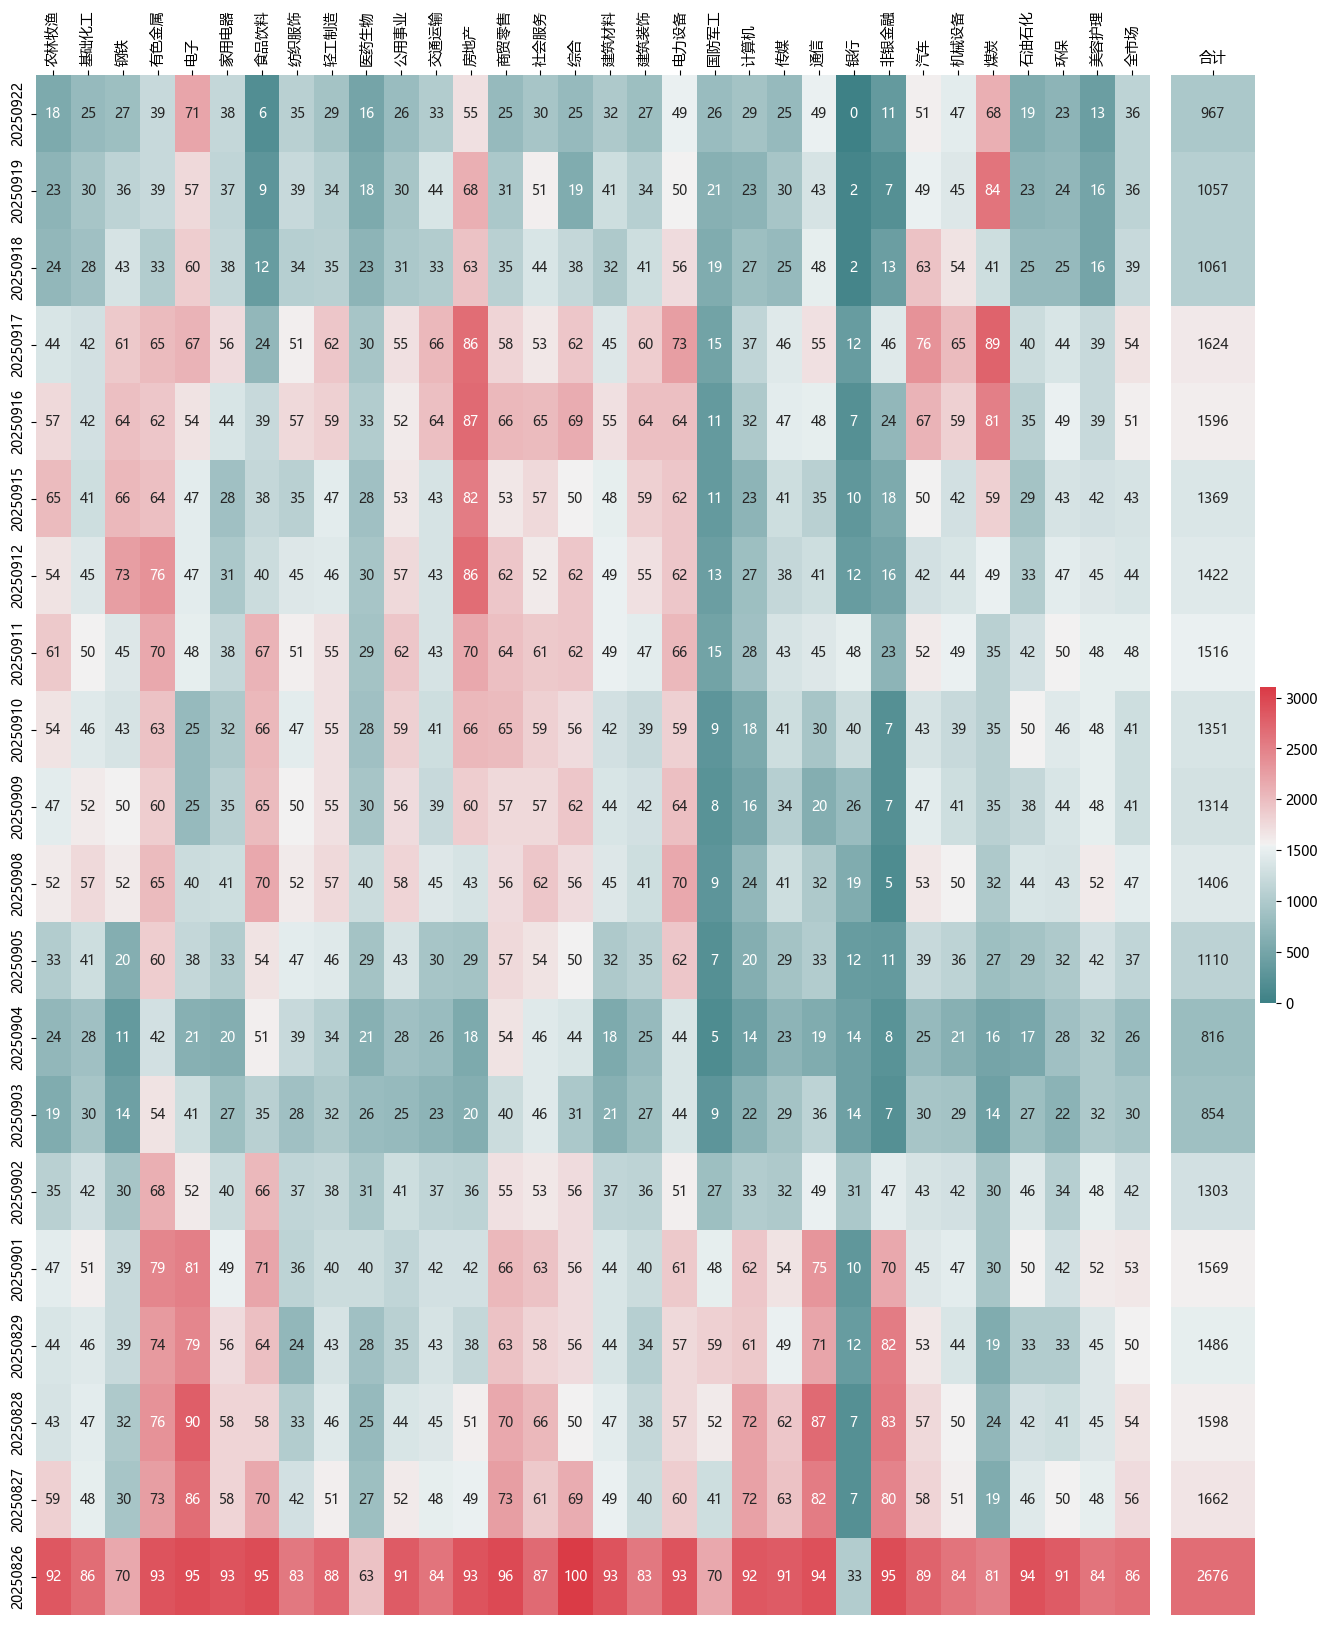

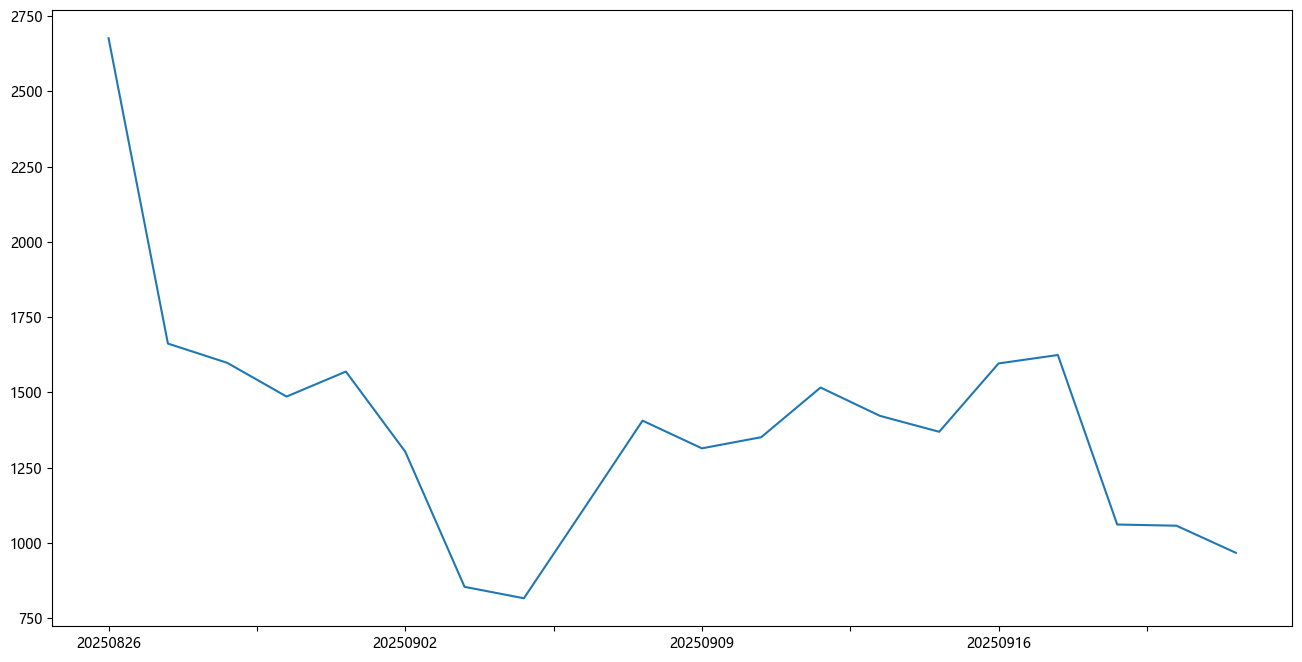

,农林牧渔,基础化工,钢铁,有色金属,电子,家用电器,食品饮料,纺织服饰,轻工制造,医药生物,...,银行,非银金融,汽车,机械设备,煤炭,石油石化,环保,美容护理,全市场,合计
,,,,,,,,,,,,,,,,,,,,,
20250922,18,25,27,39,71,38,6,35,29,16,...,0,11,51,47,68,19,23,13,36,967
20250919,23,30,36,39,57,37,9,39,34,18,...,2,7,49,45,84,23,24,16,36,1057
20250918,24,28,43,33,60,38,12,34,35,23,...,2,13,63,54,41,25,25,16,39,1061
20250917,44,42,61,65,67,56,24,51,62,30,...,12,46,76,65,89,40,44,39,54,1624
20250916,57,42,64,62,54,44,39,57,59,33,...,7,24,67,59,81,35,49,39,51,1596
20250915,65,41,66,64,47,28,38,35,47,28,...,10,18,50,42,59,29,43,42,43,1369
20250912,54,45,73,76,47,31,40,45,46,30,...,12,16,42,44,49,33,47,45,44,1422
20250911,61,50,45,70,48,38,67,51,55,29,...,48,23,52,49,35,42,50,48,48,1516
20250910,54,46,43,63,25,32,66,47,55,28,...,40,7,43,39,35,50,46,48,41,1351


In [24]:
%matplotlib inline
df = get_industry_width(end_date='20250922', count=20)
df

# 5. 策略编写和回测时常用的功能

## 5.1 过滤新三板、创业板、科创板、北交所的stock

- 根据股票代码进行筛选。

  ```python
  for stock in stock_list[:]:
      if stock[0] == '4' or stock[0] == '8' or stock[:3] == '688' or \
          stock[:3] == '300' or stock[:3] == '301' or stock[-2:] == 'BJ':
          stock_list.remove(stock)
  ```

In [25]:
stock_list = get_all_securities(day='20250620')
print(len(stock_list))
stock_list = filter_stocks(stock_list)
print(len(stock_list))

5407
3177


## 5.2 过滤st、*st 的 stock

- 我们可以用 Tushare 的 `namechange` 接口来获取每只股票的历史改名记录，然后根据历史某日股票的名字来获取该日的 st、*st股票列表，然后将这些股票从列表中剔除即可。
- Tushare 的 `namechange` 官方介绍：https://tushare.pro/document/2?doc_id=100

In [26]:
stock_list = filter_st_stock(stock_list, day='20250620')
print(len(stock_list))

3051


## 5.3 过滤停牌的 stock

- 采用 Tushare 的 `suspend_d`接口可以获取历史某日的停牌股票列表，然后将这些股票剔除即可。
- Tushare 的 `suspend_d`接口官方介绍：https://tushare.pro/document/2?doc_id=214

In [27]:
stock_list = filter_suspend_stock(stock_list, day='20250620')
print(len(stock_list))

3051


## 5.4 过滤退市的 stock

- 用 `get_stock_chinese_name` 接口获取股票的中文名称，名称中含“退”字的股票就是退市股票，将其剔除即可。
- `get_stock_chinese_name` 接口介绍见1.5.

In [28]:
stock_list = filter_delist_stock(stock_list, day='20250620')
print(len(stock_list))

3045


## 5.5 过滤今日涨停、跌停的 stock

- 用 Tushare 的 `daily` 接口可以获取某日所有股票的开盘价，用Tushare 的 `stk_limit` 接口可以获取某日所有股票的涨跌停价，因此可以用开盘价等于跌停价或涨停价作为判断来筛选某日的涨跌停股票列表，然后剔除。
- Tushare 的 `daily`接口官方介绍：https://tushare.pro/document/2?doc_id=27
- Tushare 的 `stk_limit`的官方介绍：https://tushare.pro/document/2?doc_id=183

In [29]:
stock_list = filter_limitup_limitdown_stock(stock_list, day='20250620')
print(len(stock_list))

3040


## 5.6 根据价格过滤 stock

- 用 Tushare 的 `daily` 接口来获取某日所有股票的开盘价，然后用开盘价的大小来筛选股票。
- Tushare 的 `daily`接口官方介绍：https://tushare.pro/document/2?doc_id=27

In [30]:
# 1 过滤高股价股票。例如：只保留股价在2-9元的低价股票。
stock_list = filter_price_stock(stock_list, day='20250620',  low = 2, high=9)
print(len(stock_list))

1315


In [31]:
# 2 也可以只输入 high 或者 low 来删选股票。例如只保留股价在8元以下的股票
stock_list = filter_price_stock(stock_list, day='20250620',  high=8)
print(len(stock_list))

1142


In [32]:
# 3 例如只保留股价在3元以上的股票
stock_list = filter_price_stock(stock_list, day='20250620',  low=3)
print(len(stock_list))

1012


## 5.7 过滤上市时间较短的stock

- Tushare的 `stock_basic`接口可以获取历史某日所有股票的上市日期（`list_date`），因此我们可以基于`list_date`距离计算天的天数来筛选上市时间较短的股票。
- Tushare的 `stock_basic`接口官方介绍：https://tushare.pro/document/2?doc_id=25

In [33]:
stock_list = filter_new_stock(stock_list, day='20250620',  threshold=375)
print(len(stock_list))

1011


## 5.8 获取某日st、*st 的 stock 列表

- 我们可以用 Tushare 的 `namechange` 接口来获取每只股票的历史改名记录，然后根据历史某日股票的名字来获取该日的 st、*st股票列表。
- Tushare 的 `namechange` 官方介绍：https://tushare.pro/document/2?doc_id=100

In [34]:
stock_list = get_st(day='20250620')
print(stock_list[:10])

['000004.SZ', '000070.SZ', '000430.SZ', '000488.SZ', '000504.SZ', '000518.SZ', '000595.SZ', '000608.SZ', '000609.SZ', '000615.SZ']


In [35]:
# 检验以下名称里是否带st 或者 *st
get_stock_chinese_name(stock_list[:10], day='20250620')

['*ST国华',
 'ST特信',
 'ST张家界',
 'ST晨鸣',
 '*ST生物',
 '*ST四环',
 '*ST宝实',
 '*ST阳光',
 'ST中迪',
 '*ST美谷']

# 6. 获取财务数据

## 6.1 获取历史某日利润数据

- 基于Tushare的`income`数据开发的(`pro.income`)。`pro.income`可以获取某只标的历史所有的利润表数据，我们用该接口逐一获取数据并保存在本地。
- 将所有标的的利润表数据拼接起来，要获取历史某日、某些标的的某些利润指标时，只需要用`f_ann_date`, `ts_code`, `fields`对拼接的数据进行筛选即可。
- `get_income`: `stocks`输入为空时，表示获取所有标的的数据; `fields`输入为空时，表示获取所有利润指标的数据。
- `pro.income`官方介绍：https://tushare.pro/document/2?doc_id=33

In [36]:
df = get_income(stocks=[], day='20250206', fields =[])
df 

,ann_date,f_ann_date,end_date,report_type,comp_type,end_type,basic_eps,diluted_eps,total_revenue,revenue,...,withdra_biz_devfund,withdra_rese_fund,withdra_oth_ersu,workers_welfare,distr_profit_shrhder,prfshare_payable_dvd,comshare_payable_dvd,capit_comstock_div,continued_net_profit,update_flag
ts_code,,,,,,,,,,,,,,,,,,,,,
000001.SZ,20241019,2024-10-19,20240930,1,2,3,1.9400,1.9400,1.115820e+11,1.115820e+11,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,3.972900e+10,1
000002.SZ,20241031,2024-10-31,20240930,1,1,3,-1.5132,-1.5132,2.198948e+11,2.198948e+11,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,-1.639811e+10,1
000004.SZ,20241026,2024-10-26,20240930,1,1,3,-0.2706,-0.2706,7.589438e+07,7.589438e+07,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,-3.737681e+07,1
000006.SZ,20241031,2024-10-31,20240930,1,1,3,-0.3878,-0.3878,4.827628e+09,4.827628e+09,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,-6.323969e+08,1
000007.SZ,20241031,2024-10-31,20240930,1,1,3,0.0092,0.0092,1.542257e+08,1.542257e+08,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,1.639435e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920108.BJ,20250116,2025-01-16,20231231,1,1,4,0.4900,0.4900,3.504448e+08,3.504448e+08,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,4.871994e+07,1
920111.BJ,20241026,2024-10-26,20240630,1,1,2,0.4400,0.4400,4.355682e+08,4.355682e+08,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,4.789678e+07,1
920116.BJ,20241221,2024-12-21,20231231,1,1,4,0.7900,0.7900,2.290352e+08,2.290352e+08,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,6.262792e+07,1


In [37]:
df = get_income(stocks=['000001.SZ', '000004.SZ', '920118.BJ'], day='20250206', 
                fields =['t_compr_income', 'total_revenue', 'n_income', 'operate_profit'])
df 

,t_compr_income,total_revenue,n_income,operate_profit
ts_code,,,,
000001.SZ,3.894300e+10,1.115820e+11,3.972900e+10,4.786900e+10
000004.SZ,-3.737681e+07,7.589438e+07,-3.737681e+07,-3.704201e+07
920118.BJ,4.634548e+07,1.196140e+09,4.634548e+07,5.069281e+07


## 6.2 获取历史某日资产负债数据

- 基于Tushare的`balancesheet`数据开发的(`pro.balancesheet`)。`pro.balancesheet`可以获取某只标的历史所有的资产负债表数据，我们用该接口逐一获取数据并保存在本地。
- 将所有标的的资产负债表数据拼接起来，要获取历史某日、某些标的的某些资产负债指标时，只需要用`f_ann_date`, `ts_code`, `fields`对拼接的数据进行筛选即可。
- `get_balancesheet`: `stocks`输入为空时，表示获取所有标的的数据; `fields`输入为空时，表示获取所有资产负债指标的数据。
- `pro.balancesheet`官方介绍：https://tushare.pro/document/2?doc_id=36

In [38]:
df = get_balancesheet(stocks=[], day='20250206', fields =[])
df 

,ann_date,f_ann_date,end_date,report_type,comp_type,end_type,total_share,cap_rese,undistr_porfit,surplus_rese,...,accounts_receiv_bill,accounts_pay,oth_rcv_total,fix_assets_total,cip_total,oth_pay_total,long_pay_total,debt_invest,oth_debt_invest,update_flag
ts_code,,,,,,,,,,,,,,,,,,,,,
000001.SZ,20241019,2024-10-19,20240930,1,2,3,1.940592e+10,8.071500e+10,2.398990e+11,1.078100e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.774030e+11,1.797940e+11,0
000002.SZ,20241031,2024-10-31,20240930,1,1,3,1.193071e+10,2.547076e+10,7.567300e+10,1.262275e+11,...,9.817588e+09,1.741671e+11,2.573073e+11,2.054265e+10,1.519284e+09,1.531926e+11,NaN,NaN,NaN,0
000004.SZ,20241026,2024-10-26,20240930,1,1,3,1.323803e+08,1.232192e+09,-1.218239e+09,1.341421e+07,...,1.722704e+08,9.500017e+07,2.333185e+07,1.762495e+06,1.220936e+06,1.005207e+07,800000.0,NaN,NaN,0
000006.SZ,20241031,2024-10-31,20240930,1,1,3,1.349995e+09,4.843216e+08,2.436021e+09,2.178265e+09,...,4.766501e+07,1.450390e+09,1.075937e+08,6.212249e+07,2.970870e+07,2.039994e+09,NaN,NaN,NaN,0
000007.SZ,20241031,2024-10-31,20240930,1,1,3,3.464480e+08,1.570242e+08,-3.168718e+08,8.998898e+06,...,1.660404e+07,2.274870e+07,2.634435e+07,4.553969e+07,NaN,5.535610e+07,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920108.BJ,20250116,2025-01-16,20231231,1,1,4,1.000000e+08,4.665017e+06,1.673924e+08,1.749520e+07,...,7.453507e+07,4.787663e+07,6.603239e+05,2.287804e+08,3.531475e+05,1.803826e+06,NaN,NaN,NaN,1
920111.BJ,20241026,2024-10-26,20231231,1,1,4,1.105000e+08,1.493655e+08,1.967866e+08,2.876677e+07,...,2.208953e+08,1.818985e+08,9.924020e+05,1.981772e+08,5.715817e+06,1.568354e+06,1715937.5,NaN,NaN,0
920116.BJ,20241221,2024-12-21,20231231,1,1,4,8.250000e+07,4.515013e+07,8.749229e+07,8.513602e+06,...,1.521731e+08,8.876300e+07,2.018026e+06,2.913074e+06,2.530974e+05,2.380538e+06,NaN,NaN,NaN,1


## 6.3 获取历史某日现金流量数据

- 基于Tushare的`cashflow`数据开发的(`pro.cashflow`)。`pro.cashflow`可以获取某只标的历史所有的现金流量表数据，我们用该接口逐一获取数据并保存在本地。
- 将所有标的的现金流量表数据拼接起来，要获取历史某日、某些标的的某些现金流量指标时，只需要用`f_ann_date`, `ts_code`, `fields`对拼接的数据进行筛选即可。
- `get_cashflow`: `stocks`输入为空时，表示获取所有标的的数据; `fields`输入为空时，表示获取所有现金流量指标的数据。
- `pro.cashflow`官方介绍：https://tushare.pro/document/2?doc_id=44

In [39]:
df = get_cashflow(stocks=[], day='20250304', fields =[])
df

,ann_date,f_ann_date,end_date,comp_type,report_type,end_type,net_profit,finan_exp,c_fr_sale_sg,recp_tax_rends,...,net_dism_capital_add,net_cash_rece_sec,credit_impa_loss,use_right_asset_dep,oth_loss_asset,end_bal_cash,beg_bal_cash,end_bal_cash_equ,beg_bal_cash_equ,update_flag
ts_code,,,,,,,,,,,,,,,,,,,,,
000001.SZ,20241019,2024-10-19,20240930,2,1,3,NaN,NaN,NaN,NaN,...,4.802600e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
000002.SZ,20241031,2024-10-31,20240930,1,1,3,NaN,NaN,1.494341e+11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
000004.SZ,20241026,2024-10-26,20240930,1,1,3,NaN,NaN,8.466784e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
000006.SZ,20241031,2024-10-31,20240930,1,1,3,NaN,NaN,2.094967e+09,39096562.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
000007.SZ,20241031,2024-10-31,20240930,1,1,3,NaN,NaN,1.739913e+08,4230465.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920108.BJ,20250116,2025-01-16,20231231,1,1,4,48719943.48,5332920.08,2.694853e+08,NaN,...,NaN,NaN,1074883.41,3467298.69,NaN,23049560.23,12656622.20,NaN,NaN,1
920111.BJ,20241026,2024-10-26,20240630,1,1,2,47896782.98,608078.90,3.443913e+08,1771133.55,...,NaN,NaN,3690988.48,85443.99,NaN,33414021.41,15783994.94,NaN,NaN,0
920116.BJ,20241221,2024-12-21,20231231,1,1,4,62627922.69,400701.94,1.694980e+08,282020.37,...,NaN,NaN,6129580.84,1788736.05,NaN,88099113.51,33705536.92,NaN,NaN,1


## 6.4 获取历史某日财务指标数据

- 基于Tushare的`fina_indicator`数据开发的(`pro.fina_indicator`)。`pro.fina_indicator`可以获取某只标的历史所有的财务指标数据，我们用该接口逐一获取数据并保存在本地。
- 将所有标的的财务指标数据拼接起来，要获取历史某日、某些标的的某些财务指标时，只需要用`f_ann_date`, `ts_code`, `fields`对拼接的数据进行筛选即可。
- `get_fina_indicator`: `stocks`输入为空时，表示获取所有标的的数据; `fields`输入为空时，表示获取所有财务指标的数据。
- `pro.fina_indicator`官方介绍：https://tushare.pro/document/2?doc_id=79

In [40]:
df = get_fina_indicator(stocks=[], day='20250304', fields =[])
df

,ann_date,end_date,eps,dt_eps,total_revenue_ps,revenue_ps,capital_rese_ps,surplus_rese_ps,undist_profit_ps,extra_item,...,roe_yoy,bps_yoy,assets_yoy,eqt_yoy,tr_yoy,or_yoy,q_sales_yoy,q_op_qoq,equity_yoy,update_flag
ts_code,,,,,,,,,,,,,,,,,,,,,
000001.SZ,2024-10-19,20240930,1.9400,1.9400,5.7499,5.7499,4.1593,0.5556,12.3622,-1.900000e+07,...,-4.7922,4.5000,2.8435,3.8408,-12.5766,-12.5766,-11.7210,16.6186,5.2825,None
000002.SZ,2024-10-31,20240930,-1.5132,-1.5132,18.4310,18.4310,2.1349,10.5801,6.3427,-3.475694e+09,...,-242.2990,-6.6451,-9.8130,-6.6450,-24.2548,-24.2548,-13.7558,17.4713,-7.4288,None
000004.SZ,2024-10-26,20240930,-0.2706,-0.2706,0.5733,0.5733,9.3080,0.1013,-9.2026,-2.647735e+06,...,-102.1651,-18.3227,-6.9917,-18.3188,-5.7799,-5.7799,-20.1807,-74.2112,-49.6544,None
000006.SZ,2024-10-31,20240930,-0.3878,-0.3878,3.5760,3.5760,0.3588,1.6135,1.8045,1.035346e+06,...,-51389.8298,-7.5088,-19.4063,-7.5090,482.1414,482.1414,528.5106,48.7255,-17.0461,None
000007.SZ,2024-10-31,20240930,0.0092,0.0092,0.4452,0.4452,0.4532,0.0260,-0.9146,-9.183483e+05,...,-76.9807,2.5344,-16.5755,2.5255,0.6030,0.6030,53.0767,-19.9000,27.1997,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920108.BJ,2025-01-16,20240630,0.4500,0.4500,2.3128,2.3128,0.0467,0.1750,2.1263,1.006703e+06,...,26.5189,10.3100,28.9012,10.5743,22.9205,22.9205,1.2855,-6.5251,19.4418,None
920111.BJ,2024-10-26,20240630,0.4400,0.4400,3.9418,3.9418,1.3499,0.2603,2.2211,3.601265e+05,...,10.5064,9.9800,26.4297,9.9796,65.3544,65.3544,57.1830,107.2992,19.8653,None
920116.BJ,2024-12-21,20240630,0.3100,0.3100,0.9862,0.9862,0.5473,0.1032,1.3752,1.351615e+07,...,60.8865,11.8100,2.4301,11.6063,32.3313,32.3313,35.4692,66.1905,44.3121,None


# 7. 回测模块


`analyzer(port_pnl, market_pnl, strategy, risk_free_rate=0.03, fig_name=[])`: 回测分析模块

- `port_pnl`: 投资组合的每日收益
- `market_pnl`: 基准市场的每日收益
- `strategy`: backtrader回测时生成的一个类
- `risk_free_rate`: 市场无风险利率
- `fig_name`:保存图片的名字


`analyzer`的源码如下，方便大家参考和改进：

In [41]:
################################## 回测模块 ##################################
def analyzer(port_pnl, market_pnl, strategy, risk_free_rate=0.03, fig_name=[]):
    
    stats_index = ['策略收益', '策略年化收益', '超额收益','基准收益',
                   '阿尔法','贝塔','夏普比率','胜率','盈亏比','最大回撤','索提诺比率',
                   '日均超额收益','超额收益最大回撤','超额收益夏普比率','日胜率',
                   '盈利次数','亏损次数','信息比率','策略波动率','基准波动率']
    
    stats_all = pd.Series(index = stats_index, dtype='float64')
    
    # 用pyfolio包统计时间段的收益指标，包括累计收益、年化收益、夏普比率、最大回撤、索提诺比率
    perf_stats = pf.timeseries.perf_stats((port_pnl)).to_frame(name='all')
    perf_stats_market = pf.timeseries.perf_stats((market_pnl)).to_frame(name='all')

    # 回撤序列
    cumulative = (port_pnl + 1).cumprod()/(port_pnl[0]+1)
    max_return = cumulative.cummax()
    drawdown = (cumulative - max_return) / max_return
    cumulative_market = (market_pnl + 1).cumprod()/(market_pnl[0]+1)
    
    # beta
    X = sm.add_constant(market_pnl)  # 自变量：基准收益
    y = port_pnl                     # 因变量：策略收益
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # 斜率即beta  
            
    # alpha
    annualized_strategy_return = perf_stats.loc['Annual return'][0]
    annualized_market_return = perf_stats_market.loc['Annual return'][0]
    alpha = annualized_strategy_return - \
        (risk_free_rate + beta * (annualized_market_return - risk_free_rate))

    # 策略波动率
    port_volatility = np.sqrt(250*port_pnl.var(ddof=1))
    # 基准波动率
    market_volatility = np.sqrt(250*market_pnl.var(ddof=1))
    
    # 超额收益  
    daily_ratio_alpha = (1 + port_pnl) / (1 + market_pnl) - 1   
    # 日均超额收益
    AEI = daily_ratio_alpha.mean()
    # 超额收益最大回撤
    cumulative_alpha = (daily_ratio_alpha + 1).cumprod()/(daily_ratio_alpha[0] + 1)
    max_return_alpha = cumulative_alpha.cummax()
    maxdrawdown_alpha = np.min((cumulative_alpha - max_return_alpha) / max_return_alpha)   
    # 超额收益夏普比率
    perf_stats_alpha = pf.timeseries.perf_stats((daily_ratio_alpha)).to_frame(name='all')
    sharp_ratio_alpha = perf_stats_alpha.loc['Sharpe ratio'][0]
    
    # 日胜率
    daily_win = port_pnl > market_pnl  # 返回布尔序列（True表示跑赢）
    total_days = len(daily_win)
    win_days = daily_win.sum()  # True的个数即为赢的天数
    daily_win_rate = (win_days / total_days) 
    
    # 信息比率
    daily_stdv = (port_pnl - market_pnl).std()
    annualized_stdv = daily_stdv * np.sqrt(250)    
    information_ratio = \
        (perf_stats.loc['Annual return'][0] - perf_stats_market.loc['Annual return'][0])/annualized_stdv
    
    # 胜率、盈亏比、盈利次数、亏损次数
    wins = [x for x in strategy.trades if x > 0]  # 盈利交易
    losses = [x for x in strategy.trades if x <= 0] # 亏损交易
    total_trades = len(strategy.trades)
    win_rate = len(wins) / total_trades if total_trades > 0 else 0
    total_profit = sum(wins)
    total_loss = abs(sum(losses))
    profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')    
    
    stats_all.loc['策略收益'] = perf_stats.loc['Cumulative returns'][0]
    stats_all.loc['策略年化收益'] = perf_stats.loc['Annual return'][0]
    stats_all.loc['超额收益'] = cumulative_alpha[-1] - 1
    stats_all.loc['基准收益'] = perf_stats_market.loc['Cumulative returns'][0]
    stats_all.loc['阿尔法'] = alpha
    stats_all.loc['贝塔'] = beta
    stats_all.loc['夏普比率'] = perf_stats.loc['Sharpe ratio'][0]
    stats_all.loc['胜率'] = win_rate
    stats_all.loc['盈亏比'] = profit_factor
    stats_all.loc['最大回撤'] = abs(perf_stats.loc['Max drawdown'][0])
    stats_all.loc['索提诺比率'] = perf_stats.loc['Sortino ratio'][0]
    stats_all.loc['日均超额收益'] = AEI
    stats_all.loc['超额收益最大回撤'] = abs(maxdrawdown_alpha)
    stats_all.loc['超额收益夏普比率'] = sharp_ratio_alpha
    stats_all.loc['日胜率'] = daily_win_rate
    stats_all.loc['盈利次数'] = len(wins)
    stats_all.loc['亏损次数'] = len(losses)
    stats_all.loc['信息比率'] = information_ratio
    stats_all.loc['策略波动率'] = port_volatility
    stats_all.loc['基准波动率'] = market_volatility
    
    # plot
    fig, (ax0, ax1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 6]}, figsize=(19,  8.93))
    # 定义格式
    percentage_fields = ['策略收益', '策略年化收益', '超额收益', '基准收益', 
                         '日均超额收益','最大回撤', '超额收益最大回撤']
    integer_fields = ['盈利次数', '亏损次数']
    
    # 格式化数据
    formatted_stats = []
    for index, value in stats_all.items():
        if pd.isna(value):
            formatted_stats.append((index, "NaN"))
        elif index in percentage_fields:
            formatted_stats.append((index, f"{value * 100:.2f}%"))
        elif index in integer_fields:
            formatted_stats.append((index, f"{int(value)}"))
        else:
            formatted_stats.append((index, f"{value:.3f}"))  
            
    # 创建表格数据
    table_data = [[item[0], item[1]] for item in formatted_stats]
    
    # 创建表格
    table = ax0.table(cellText=table_data,
                     colLabels=["指标", "数值"],
                     cellLoc="center",
                     loc="center",
                     colColours=["#f2f2f2", "#f2f2f2"])
    
    # 美化表头
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight="bold", color="black")
            cell.set_facecolor("#dcdcdc")
            cell.set_edgecolor("black")
        cell.set_edgecolor("lightgray")
        cell.set_linewidth(1.2)
    
    # 调整表格字体和大小
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.9)  # 调大行间距       
    ax0.axis("off")
    
    # 绘制累计收益曲线
    ax2 = ax1.twinx()
    ax1.yaxis.set_ticks_position('right') # 将回撤曲线的 y 轴移至右侧
    ax2.yaxis.set_ticks_position('left') # 将累计收益曲线的 y 轴移至左侧
    # 绘制回撤曲线
    drawdown.plot.area(ax=ax1, label='策略回撤 (right)', rot=0, alpha=0.3, 
                       fontsize=13, grid=False)
    # 绘制累计收益曲线
    (cumulative).plot(ax=ax2, color='#F1C40F' , lw=3.0, label='策略收益 (left)', 
                      rot=0, fontsize=13, grid=False)
    # Ashare累计收益曲线
    (cumulative_market).plot(ax=ax2, color='red' , label='指数收益 (left)', 
                             rot=0, fontsize=13, grid=False)

    # 不然 x 轴留有空白
    ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
    # 同时绘制双轴的图例
    h1,l1 = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2,l1+l2, fontsize=12, loc='upper left', ncol=1)
    fig.tight_layout() 
    plt.title(fig_name)
    
    since, until = port_pnl.index[0].strftime('%Y%m%d'), port_pnl.index[-1].strftime('%Y%m%d')

    if len(fig_name)>0:
        plt.savefig(fig_name + '_backtest_' + since + '_' + until + '.png')
    else:
        plt.savefig('backtest_' + since + '_' + until + '.png')
        
    plt.show()
    
    return stats_all